# Example: Analyzing Citibike Station Activity using Pandas

We are going to use the database of snapshots of Citibike stations statuses. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

In [5]:
!sudo apt-get update
!sudo pip3 install -U sklearn geopandas sqlalchemy

!sudo apt-get install -y python3-mysqldb
!sudo pip3 install -U sqlalchemy sql_magic

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done
Requirement already up-to-date: sklearn in /usr/local/lib/python3.8/dist-packages (0.0)
Requirement already up-to-date: geopandas in /usr/local/lib/python3.8/dist-packages (0.8.1)
Requirement already up-to-date: sqlalchemy in /usr/local/lib/python3.8/dist-packages (1.3.20)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmysqlclient21 mysql-common
Suggested packages:
  default-mysql-server | virtual-mysql-server python3-mysqldb-dbg
The following NEW packages will be installed:
  libmysqlclient21 mysql-common python3-mysqldb
0 upgraded, 3 newly installed, 0 to remove and 46 not upgraded.
Need to get 1,276 kB of

## Fetching Data

We will first fetch the data from the database. The original SQL query on the raw data is the following, and is computing the average capacity of a bike station in hourly intervals.

```sql
    SELECT S.station_id AS id, 
           AVG(num_bikes_available) AS available_bikes,
           AVG(num_docks_available) AS available_docks,
           AVG(num_bikes_disabled) AS disabled_bikes,
           AVG(num_docks_disabled) AS disabled_docks,
           T.capacity, T.lat, T.lon, T.name,
           DATE_FORMAT(last_reported, '%%Y-%%m-%%d %%H:00:00') AS communication_time 
    FROM citibike_new.Status S JOIN citibike_new.Stations T ON T.station_id = S.station_id
    WHERE  is_renting=1 AND is_installed=1 AND T.capacity>0 AND last_reported>='2017-10-01' AND last_reported<='2017-11-15'
    GROUP BY S.station_id, communication_time
```

For speed, we store the results of this query in a table.

In [6]:
%%time
from sqlalchemy import create_engine

conn_string = 'mysql://{user}:{password}@{host}/{database}?charset={encoding}'.format(
    host = 'db.ipeirotis.org', 
    user = 'student',
    password = 'dwdstudent2015',
    database = 'citibike_fall2017',
    encoding = 'utf8mb4')
engine = create_engine(conn_string)

query = '''
SELECT *
FROM status_fall2017
'''
df = pd.read_sql(query, con=engine)
df.communication_time = pd.to_datetime(df.communication_time, format='%Y-%m-%d %H:%M:%S')


CPU times: user 2.88 s, sys: 537 ms, total: 3.42 s
Wall time: 5.09 s


In [7]:
len(df)

541075

In [8]:
df.head(5)

id  available_bikes  available_docks  disabled_bikes  disabled_docks  \
0  72          16.0000          22.0000             1.0             0.0   
1  72          16.7500          21.2500             1.0             0.0   
2  72          14.0000          24.0000             1.0             0.0   
3  72          15.5000          22.5000             1.0             0.0   
4  72          15.4286          22.5714             1.0             0.0   

   capacity      lat      lon              name  communication_time  
0        39  40.7673 -73.9939  W 52 St & 11 Ave 2017-10-01 00:00:00  
1        39  40.7673 -73.9939  W 52 St & 11 Ave 2017-10-01 01:00:00  
2        39  40.7673 -73.9939  W 52 St & 11 Ave 2017-10-01 02:00:00  
3        39  40.7673 -73.9939  W 52 St & 11 Ave 2017-10-01 03:00:00  
4        39  40.7673 -73.9939  W 52 St & 11 Ave 2017-10-01 05:00:00

### Exploratory Analysis

As a first step, let's see how the status of the bike stations evolves over time. We compute the average "**fullness**" of **all** the bike stations over time.

In [9]:
df['percent_full'] = df.available_bikes / df.capacity

Now let's plot the activity over time. We can see that the percentage of bikes in the stations fluctuates over time, with around 10% difference from the daily-lows to the daily-highs. 

<AxesSubplot:xlabel='communication_time'>

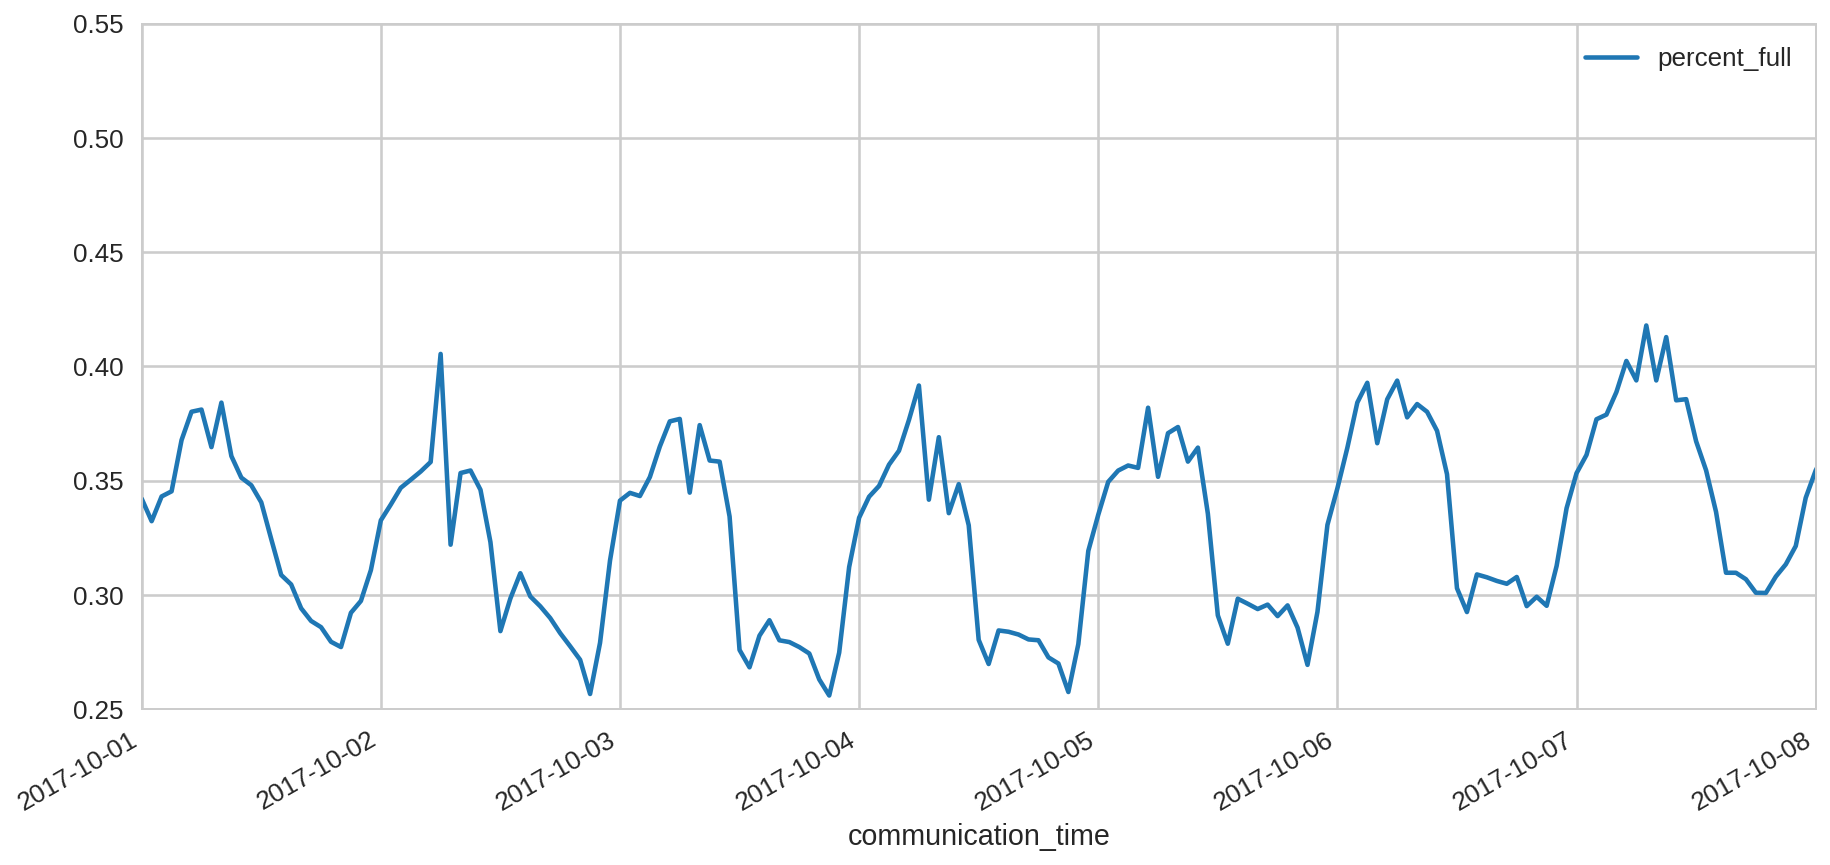

In [10]:
timeseries = df.pivot_table(
    index='communication_time', 
    values='percent_full',
    aggfunc='mean'
)

timeseries.plot( figsize=(15, 7), ylim=(0.25,0.55), xlim=('2017-10-01', '2017-10-08'))

Let's do also the seasonal decomposition to see the result.

<ipython-input-11-56f802d1936d>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(timeseries, model='multiplicative', freq=24)


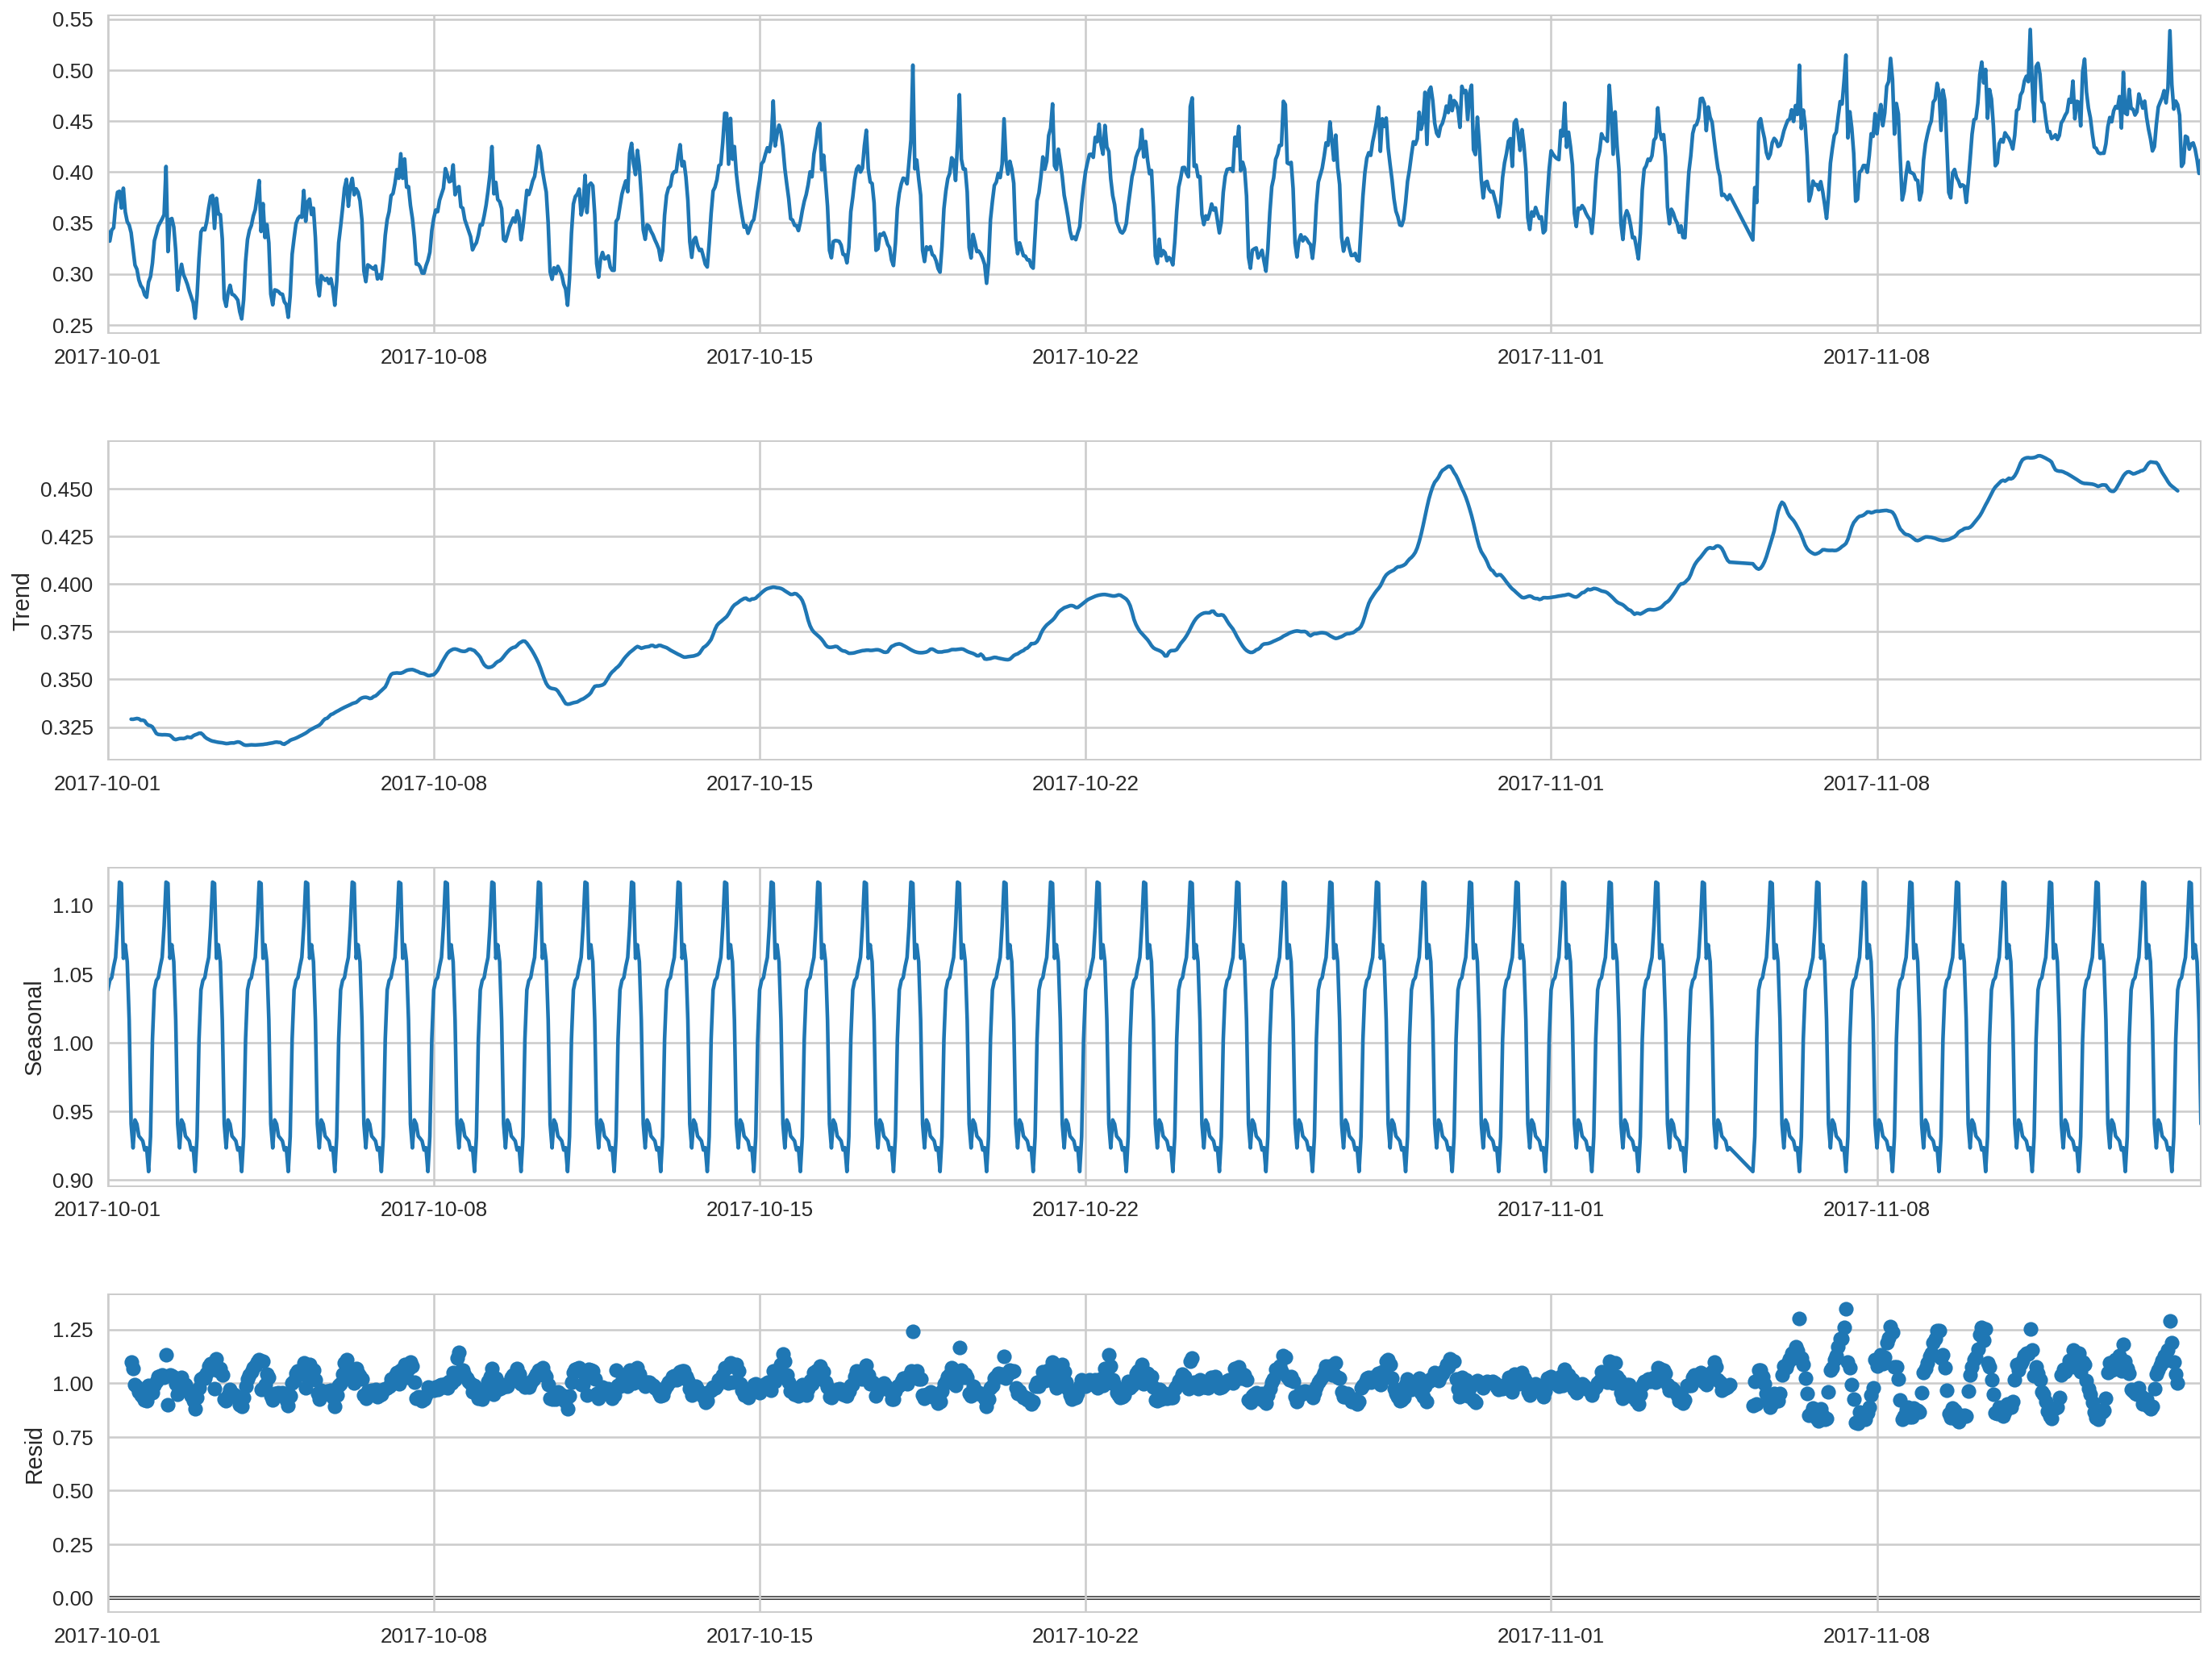

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(timeseries, model='multiplicative', freq=24)
seasonal = decomposition.plot()  
seasonal.set_size_inches(20, 15)

### Examining Time Series per Station

We now create a pivot table, to examine the time series for individual stations.

Notice that we use the `interpolate` method, where we fill the cells using interpolation using the non-missing values before and after.

In [12]:
station_timeseries = df.pivot_table(
    index='communication_time', 
    columns='id', 
    values='percent_full', 
    aggfunc='mean'
).interpolate(method='time') 

station_timeseries.head(5)

id                       72        79        82        83        116   \
communication_time                                                      
2017-10-01 00:00:00  0.410256  0.072727  0.148148  0.508065  0.141026   
2017-10-01 01:00:00  0.429487  0.060606  0.129630  0.493548  0.124541   
2017-10-01 02:00:00  0.358974  0.030303  0.185185  0.467742  0.051282   
2017-10-01 03:00:00  0.397436  0.025974  0.240741  0.493952  0.108974   
2017-10-01 04:00:00  0.396521  0.021645  0.259259  0.489247  0.256410   

id                       119       120       127       128       143   ...  \
communication_time                                                     ...   
2017-10-01 00:00:00  0.500000  0.105263  0.458781  0.941667  0.020833  ...   
2017-10-01 01:00:00  0.505263  0.052632  0.322581  0.900000  0.020833  ...   
2017-10-01 02:00:00  0.510526  0.026316  0.304658  0.944443  0.020833  ...   
2017-10-01 03:00:00  0.515789  0.000000  0.361290  0.876190  0.031250  ...   
2017-10-01 04:00:00  0.521053  0.052632  0.380645  0.804167  0.041667  ...   

id                       3506      3509      3511      3535      3536  \
communication_time                                                      
2017-10-01 00:00:00       NaN       NaN  0.136364  0.166667  0.046512   
2017-10-01 01:00:00       NaN  0.064516  0.181818  0.164815  0.007751   
2017-10-01 02:00:00  0.034483  0.088710  0.136364  0.162963  0.012919   
2017-10-01 03:00:00  0.034483  0.112903  0.181818  0.161111  0.018088   
2017-10-01 04:00:00  0.034483  0.161290  0.190909  0.159259  0.023256   

id                       3542      3551      3552      3553      3632  
communication_time                                                     
2017-10-01 00:00:00       NaN  0.130435       NaN  0.108108  0.109091  
2017-10-01 01:00:00       NaN  0.130435  0.025641  0.144143  0.151515  
2017-10-01 02:00:00  0.017241  0.152174  0.000000  0.243243  0.115152  
2017-10-01 03:00:00  0.034483  0.173913  0.000000  0.279278  0.260606  
2017-10-01 04:00:00  0.045978  0.195652  0.000000  0.310811  0.356061  

[5 rows x 683 columns]

Let's plot the time series for *all* bike stations, for a few days.

<AxesSubplot:xlabel='communication_time'>

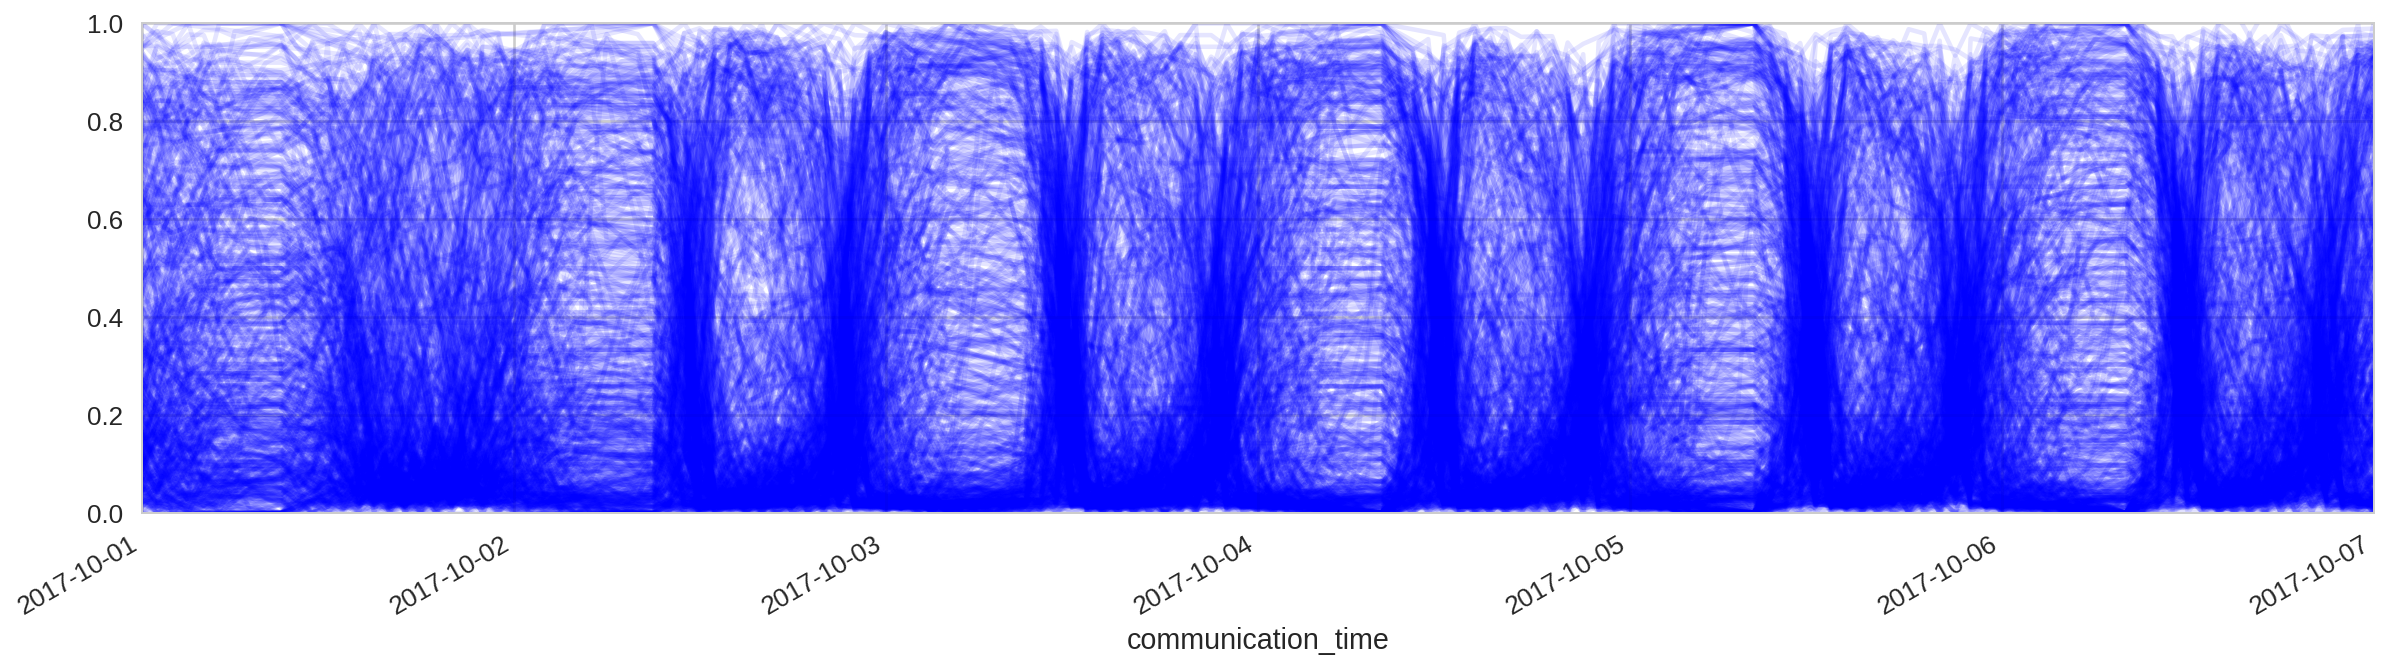

In [13]:
station_timeseries.plot(
    alpha=0.1, 
    color='b', 
    legend=False, 
    figsize=(20,5), 
    xlim=('2017-10-01','2017-10-07'),
    ylim=(0,1)
)

Let's limit our plot to just two stations:
* Station 3260 at "Mercer St & Bleecker St"
* Station 161 at "LaGuardia Pl & W 3 St"

which are nearby and tend to exhibit similar behavior. Remember that the list of stations is [available as a JSON](https://feeds.citibikenyc.com/stations/stations.json) 

In [14]:
# df [ df.name.str.contains("Mercer") & df.name.str.contains("Bleecker") ]
# df [ df.name.str.contains("LaGuardia") ]

<AxesSubplot:xlabel='communication_time'>

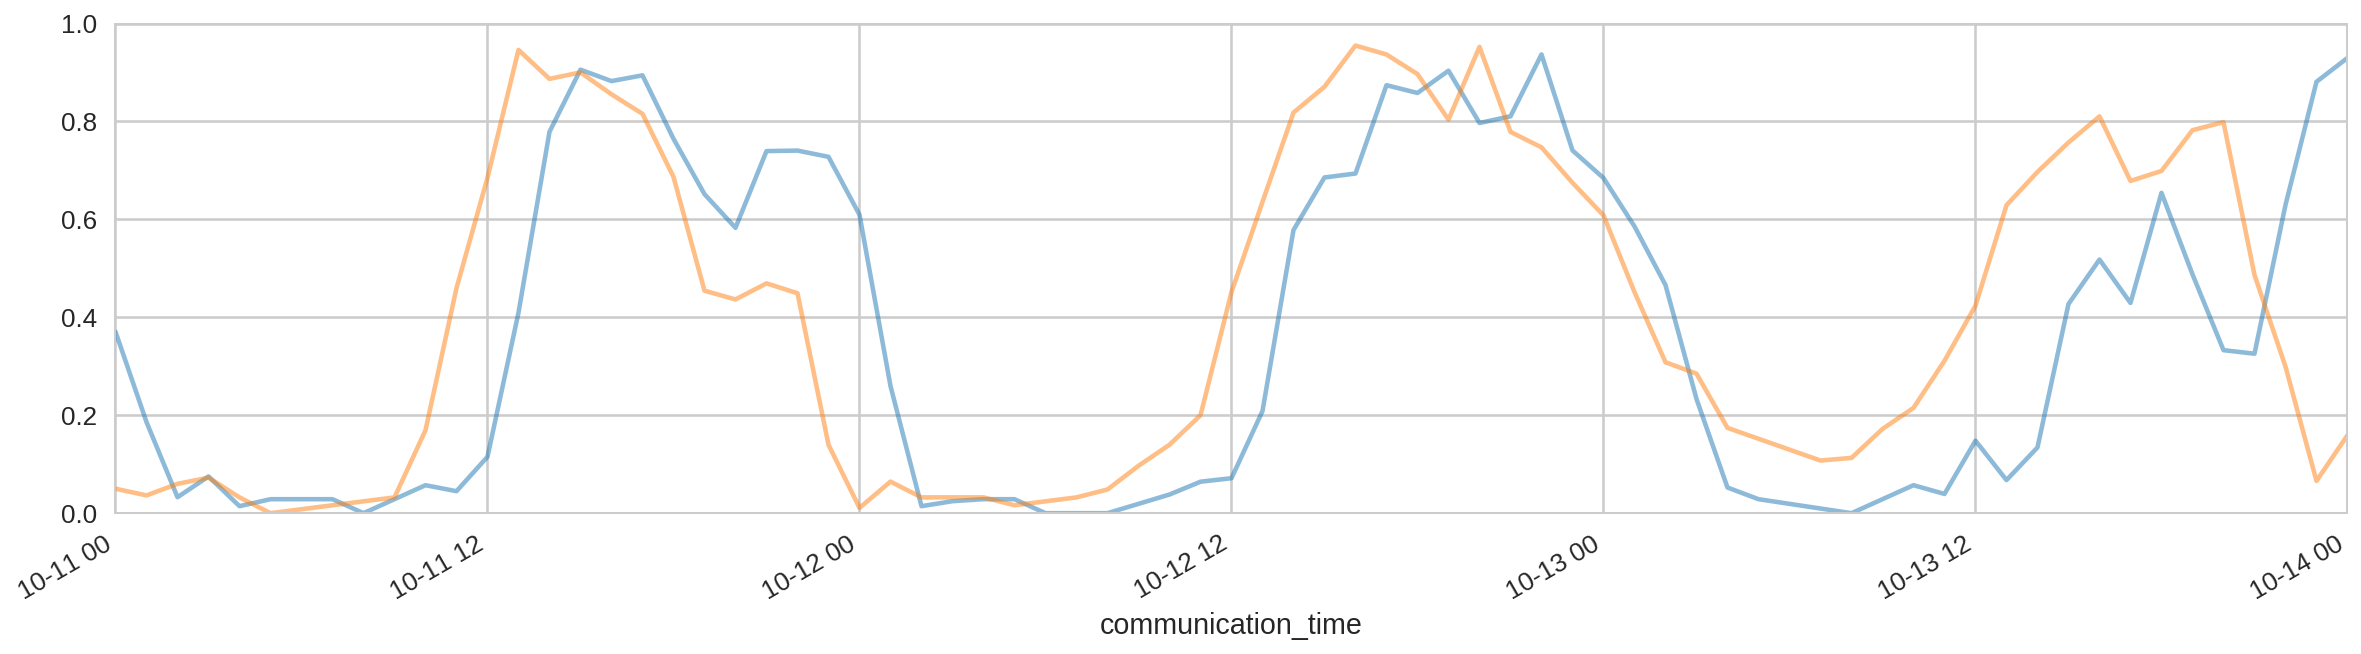

In [15]:
station_timeseries[ [161, 3260] ].plot(
    alpha=0.5,  
    legend=False, 
    figsize=(20,5), 
    xlim=('2017-10-11','2017-10-14'),
    ylim=(0,1)
)

## Finding Bike Stations with Similar Behavior

For our next analysis, we are going to try to find bike stations that have similar behaviors over time. A very simple technique that we can use to find similar time series is to treat the time series as vectors, and compute their correlation. Pandas provides the `corr` function that can be used to calculate the correlation of columns. (If we want to compute the correlation of rows, we can just take the transpose of the dataframe using the `transpose()` function, and compute the correlations there.)

In [16]:
similarities = station_timeseries.corr(method='pearson')
similarities.head(5)

id       72        79        82        83        116       119       120   \
id                                                                          
72   1.000000 -0.347045  0.232946 -0.167227  0.093290  0.171986  0.297095   
79  -0.347045  1.000000  0.097550  0.453438  0.311674 -0.138293 -0.456938   
82   0.232946  0.097550  1.000000  0.074904  0.104074  0.067588  0.087829   
83  -0.167227  0.453438  0.074904  1.000000  0.277944 -0.192117 -0.413392   
116  0.093290  0.311674  0.104074  0.277944  1.000000  0.207111 -0.249466   

id       127       128       143   ...      3506      3509      3511  \
id                                 ...                                 
72   0.233466 -0.235597 -0.140796  ...  0.063324  0.294699  0.211622   
79  -0.235306  0.350069  0.398496  ...  0.165300  0.262670 -0.134893   
82   0.335759  0.059021 -0.074860  ...  0.162258  0.227383  0.272078   
83  -0.172348  0.401813  0.278734  ...  0.081840  0.234099  0.131422   
116 -0.046407  0.011315  0.236189  ... -0.087437  0.337434  0.253603   

id       3535      3536      3542      3551      3552      3553      3632  
id                                                                         
72   0.119909 -0.108542 -0.180642  0.291919  0.156979  0.373690  0.330081  
79  -0.201125  0.367742  0.355370 -0.312069  0.022535 -0.277437 -0.473167  
82   0.135422  0.207336  0.196475 -0.016738  0.209621  0.251452  0.136888  
83  -0.110038  0.326383  0.315282 -0.287316  0.043190 -0.231002 -0.403371  
116 -0.065873  0.201512  0.122817 -0.229537 -0.005275 -0.009582 -0.164603  

[5 rows x 683 columns]

Let's see the similarities of the two stations that we examined above.

In [17]:
stations = [161, 3260]

similarities[stations].loc[stations]

id        161       3260
id                      
161   1.000000  0.692026
3260  0.692026  1.000000

In [18]:
# 393: E 5 St & Avenue C
# 2003: 1 Ave & E 18 St
stations = [393, 2003] 
    
similarities[stations].loc[stations]

id        393       2003
id                      
393   1.000000  0.891826
2003  0.891826  1.000000

<AxesSubplot:xlabel='communication_time'>

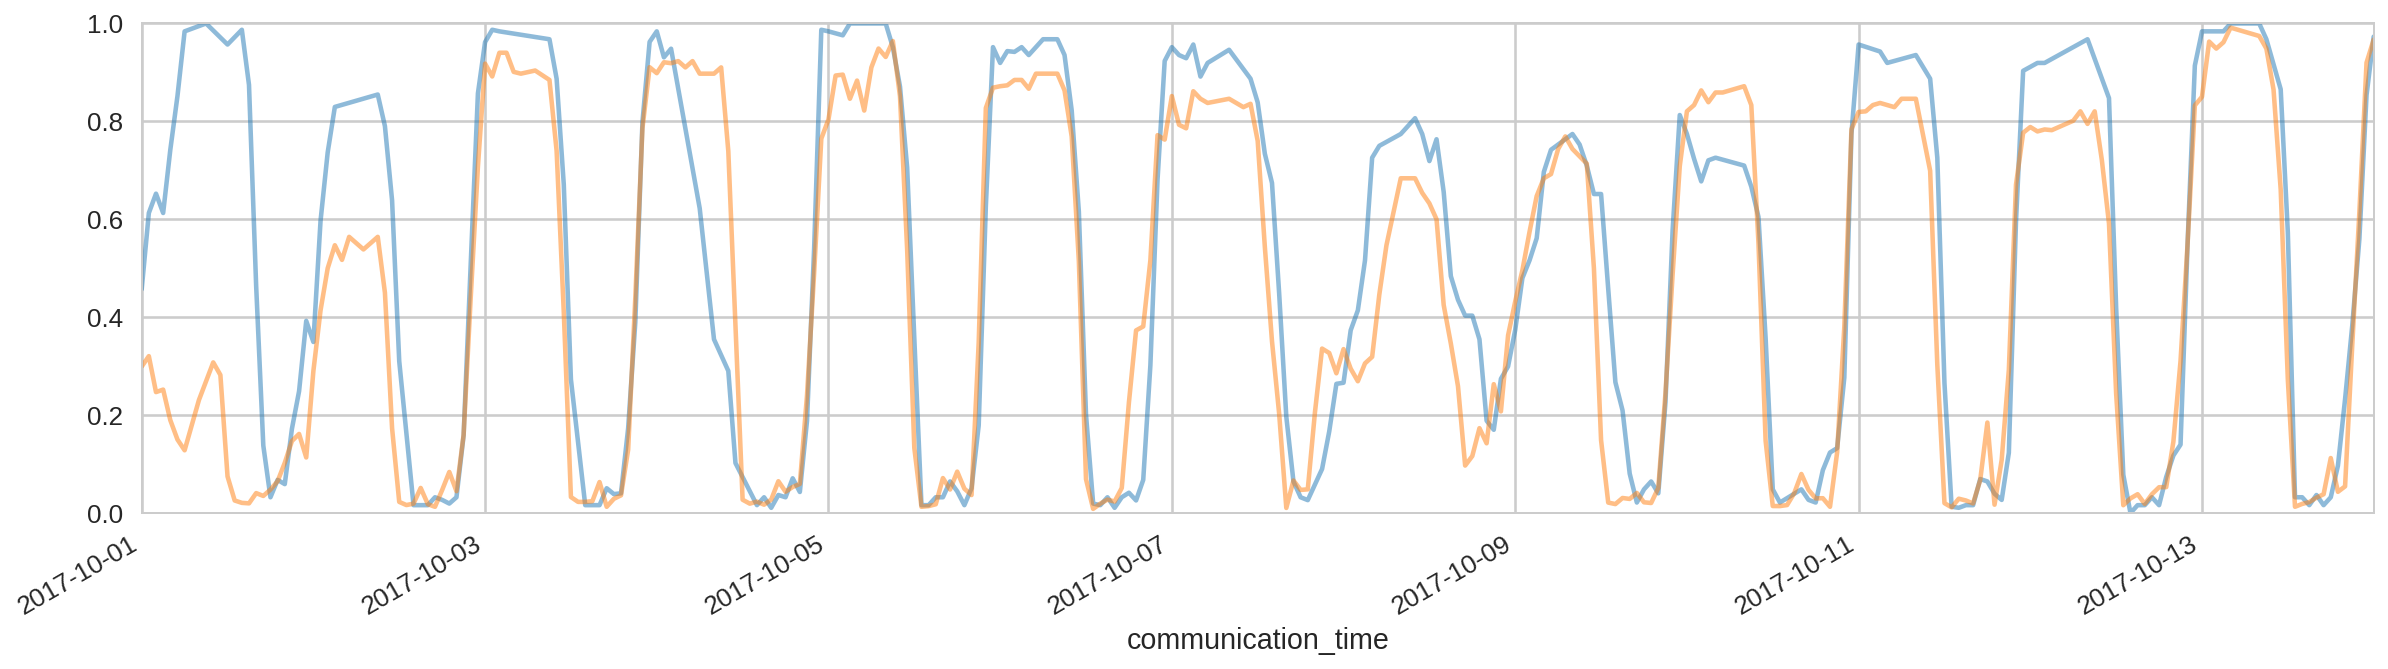

In [19]:
station_timeseries[ [393, 2003]  ].plot(
    alpha=0.5,  
    legend=False, 
    figsize=(20,5), 
    xlim=('2017-10-01','2017-10-14'),
    ylim=(0,1)
)

For bookkeeping purposes, we are going to drop stations that generate NaN values, as we cannot use such entries for our analysis.

In [20]:
# Number of stations with non-NaN similarity per station
check = similarities.count()
# Find the number of stations with less than the max number of similarities
todrop = check[check < check.max()].index.values
similarities.drop(todrop, axis='index', inplace=True)
similarities.drop(todrop, axis='columns', inplace=True)

### Clustering Based on Distances

Without explaining too much about clustering, we are going to use a clustering technique and cluster together bike stations that are "nearby" according to our similarity analysis. For this, we need to first convert our similarities to distance.

We are now going to convert our **similarities** into **distance** metrics. Our distance values will be always positive, and bounded between 0 and 1.

* If two stations have correlation 1, they behave identically, and therefore have distance 0, 
* If two stations have correlation -1, they have exactly the oppositite behaviors, and therefore we want to have distance 1 (the max) 

In [21]:
# Similarity goes from -1 to 1, so 1-similarity goes from 0 to 2.
# So, we multiply with 0.5 to get it between 0 and 1, and then take the square
distances = ((.5*(1-similarities))**2)
distances.head(5)

id       72        79        82        83        116       119       120   \
id                                                                          
72   0.000000  0.453633  0.147093  0.340605  0.205531  0.171402  0.123519   
79   0.453633  0.000000  0.203604  0.074683  0.118448  0.323928  0.530667   
82   0.147093  0.203604  0.000000  0.213951  0.200671  0.217348  0.208014   
83   0.340605  0.074683  0.213951  0.000000  0.130341  0.355286  0.499419   
116  0.205531  0.118448  0.200671  0.130341  0.000000  0.157168  0.390291   

id       127       128       143   ...      3506      3509      3511  \
id                                 ...                                 
72   0.146894  0.381675  0.325354  ...  0.219340  0.124362  0.155385   
79   0.381495  0.105603  0.090452  ...  0.174181  0.135914  0.321995   
82   0.110304  0.221360  0.288831  ...  0.175453  0.149234  0.132468   
83   0.343600  0.089457  0.130056  ...  0.210754  0.146651  0.188607   
116  0.273742  0.244374  0.145852  ...  0.295630  0.109748  0.139277   

id       3535      3536      3542      3551      3552      3553      3632  
id                                                                         
72   0.193640  0.307216  0.348479  0.125345  0.177671  0.098066  0.112198  
79   0.360676  0.099938  0.103887  0.430381  0.238859  0.407961  0.542555  
82   0.186874  0.157079  0.161413  0.258439  0.156175  0.140081  0.186241  
83   0.308046  0.113440  0.117210  0.414295  0.228872  0.378842  0.492363  
116  0.284021  0.159396  0.192362  0.377940  0.252644  0.254814  0.339075  

[5 rows x 673 columns]

The clustering code is very simple: The code below will create two groups of stations.

In [22]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=2)
cluster.fit(distances.values)

KMeans(n_clusters=2)

We will now take the results of the clustering and associate each of the data points into a cluster.

In [23]:
labels = pd.DataFrame(list(zip(distances.index.values.tolist(), cluster.labels_)), columns = ["id", "cluster"])
labels.head(10)

id  cluster
0   72        0
1   79        1
2   82        0
3   83        1
4  116        1
5  119        0
6  120        0
7  127        0
8  128        1
9  143        1

Let's see how many stations in each cluster

In [24]:
labels.pivot_table(
    index = 'cluster',
    aggfunc = 'count'
)

id
cluster     
0        420
1        253

### Visualizing the Time Series Clusters

We will start by assining a color to each cluster, so that we can plot each station-timeline with the cluster color. (We put a long list of colors, so that we can play with the number of clusters in the earlier code, and still get nicely colored results.)

In [25]:
colors = list(['red','blue', 'green', 'magenta', 'yellow', 'black', 'white', 'cyan'])
labels['color'] = labels['cluster'].apply(lambda cluster_id : colors[cluster_id]) 
labels.head(10)

id  cluster color
0   72        0   red
1   79        1  blue
2   82        0   red
3   83        1  blue
4  116        1  blue
5  119        0   red
6  120        0   red
7  127        0   red
8  128        1  blue
9  143        1  blue

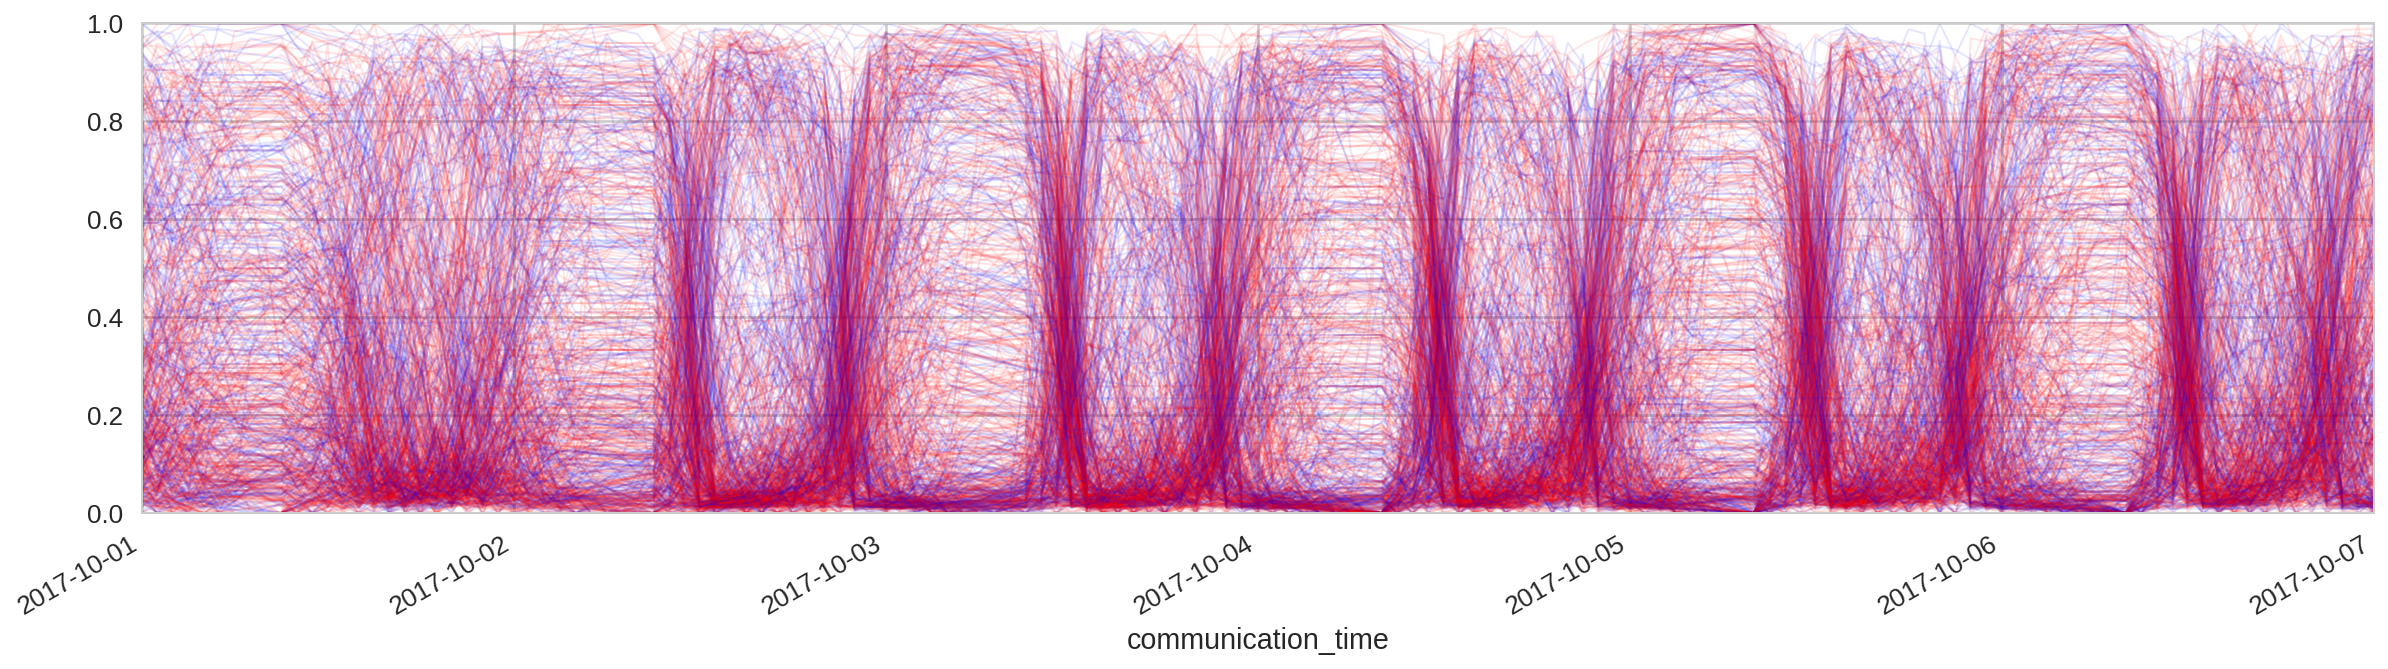

In [26]:
stations_plot = station_timeseries.plot(
    alpha=0.1, 
    legend=False, 
    figsize=(20,5), 
    linewidth=1,
    color=labels["color"],
    xlim=('2017-10-01','2017-10-07'),
    ylim=(0,1)
)

The plot still looks messy. Let's try to plot instead a single line for each cluster. To represent the cluster, we are going to use the _median_ fullness value across all stations that belong to a cluster, for each timestamp. For that, we can again use a pivot table: we define the `communication_time` as one dimension of the table, and `cluster` as the other dimension, and we use the `median` function. 

For that, we first _join_ our original dataframe with the results of the clustering, using the `merge` command, and add an extra column that includes the clusterid for each station. Then we compute the pivot table.

In [27]:
median_cluster = df.merge(
    labels, 
    how='inner', 
    on='id'
).pivot_table(
    index='communication_time', 
    columns='cluster', 
    values='percent_full', 
    aggfunc='median'
)

median_cluster.head(15)

cluster                     0         1
communication_time                     
2017-10-01 00:00:00  0.290323  0.198718
2017-10-01 01:00:00  0.308641  0.188171
2017-10-01 02:00:00  0.347826  0.191918
2017-10-01 03:00:00  0.338755  0.168892
2017-10-01 04:00:00  0.381680  0.189911
2017-10-01 05:00:00  0.415230  0.217391
2017-10-01 06:00:00  0.427069  0.212121
2017-10-01 07:00:00  0.418860  0.191973
2017-10-01 08:00:00  0.425000  0.168880
2017-10-01 09:00:00  0.372093  0.166667
2017-10-01 10:00:00  0.387627  0.171921
2017-10-01 11:00:00  0.370968  0.175666
2017-10-01 12:00:00  0.355198  0.185185
2017-10-01 13:00:00  0.285714  0.205882
2017-10-01 14:00:00  0.252483  0.235618

Now, we can plot the medians for the two clusters.

<AxesSubplot:xlabel='communication_time'>

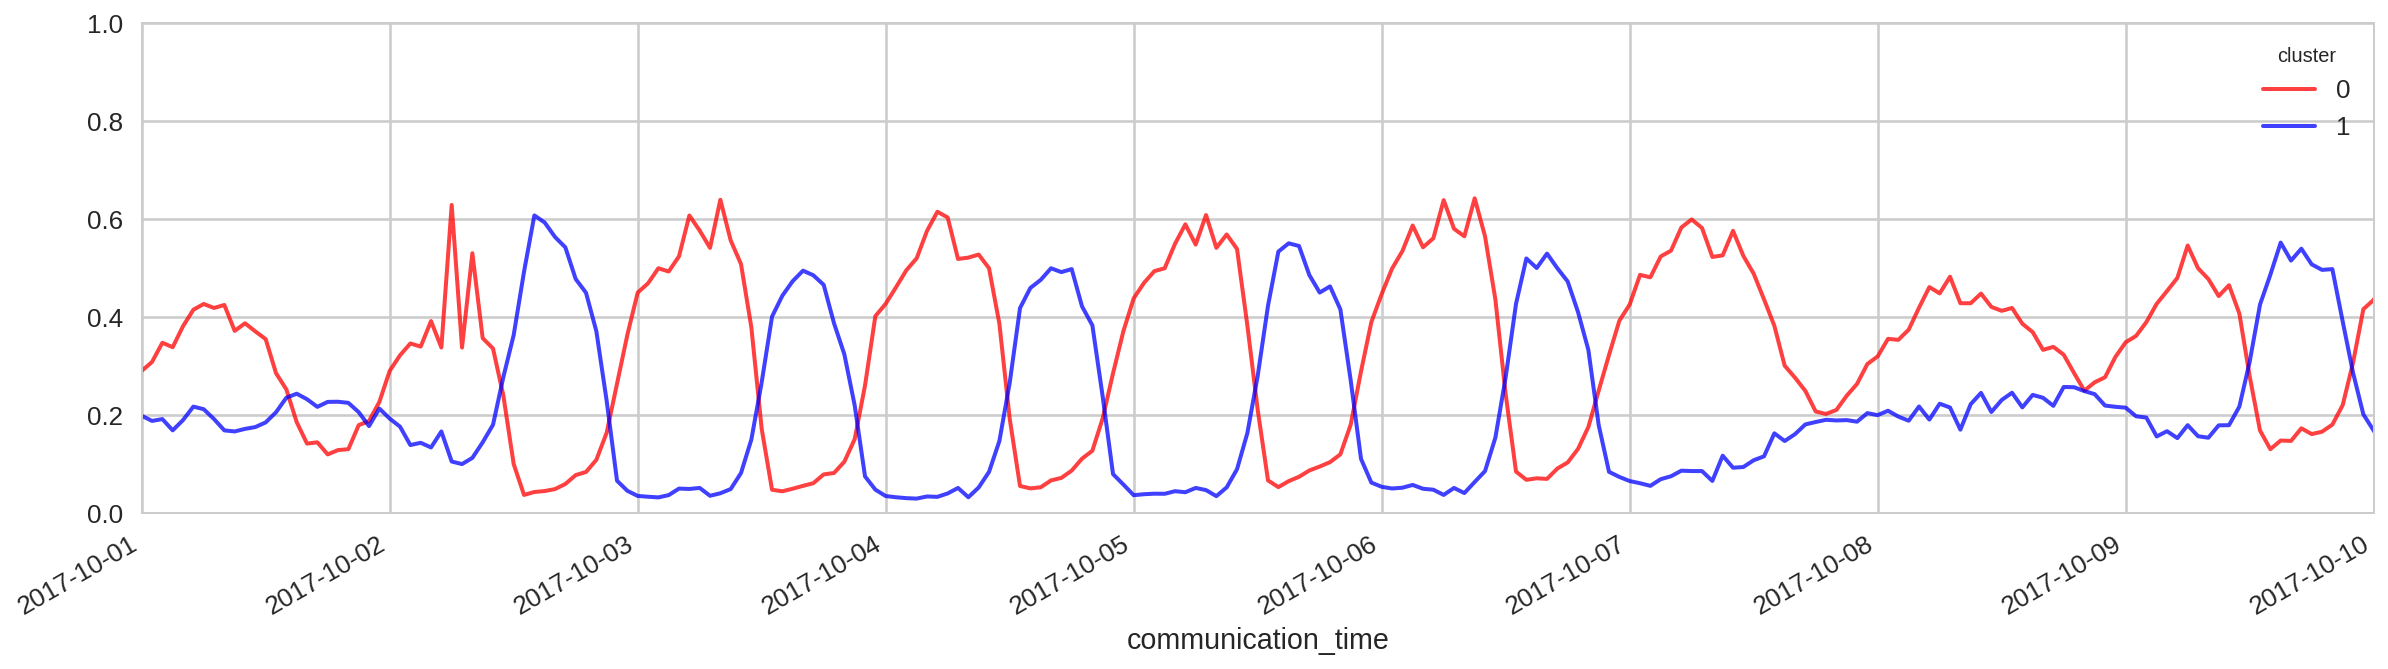

In [28]:
median_cluster.plot(
    figsize=(20,5), 
    linewidth = 2, 
    alpha = 0.75,
    color=colors,
    ylim = (0,1),
    xlim=('2017-10-01','2017-10-10'),
    grid = True
)

And just for fun and for visual decoration, let's put the two plots together. We are going to fade a lot the individual station time series (by putting the `alpha=0.005`) and we are going to make more prominent the median lines by increasing their linewidths. We will limit our plot to one week's worth of data:

<AxesSubplot:xlabel='communication_time'>

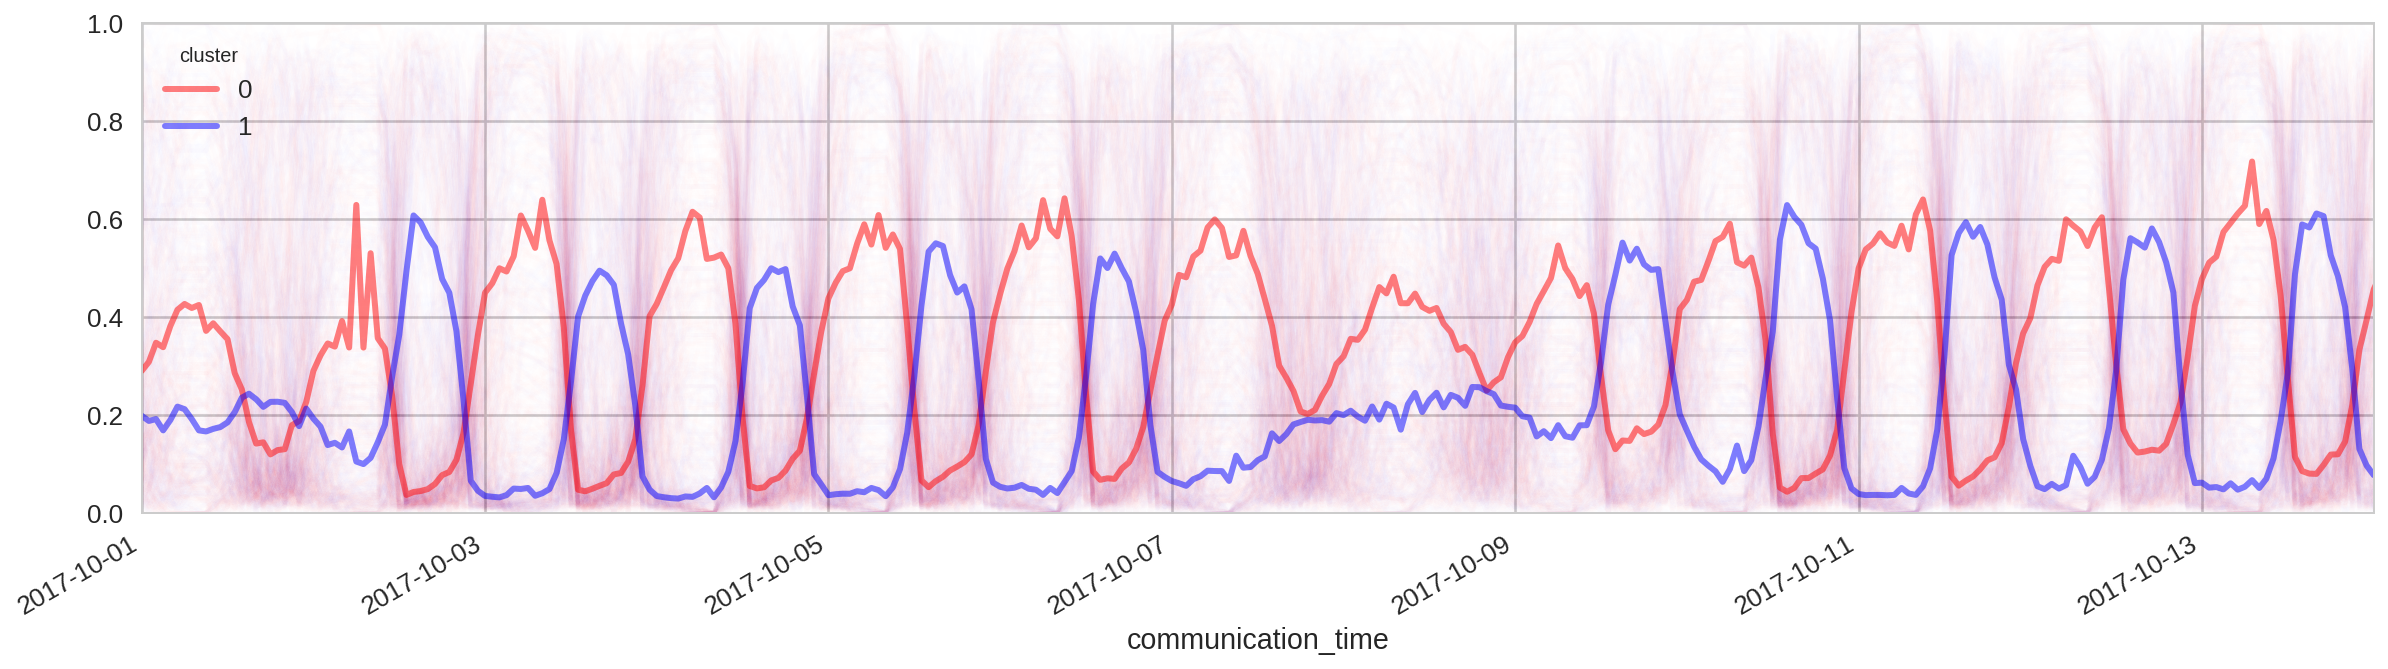

In [29]:
stations_plot = station_timeseries.plot(
    alpha=0.005, 
    legend=False, 
    figsize=(20,5), 
    color=labels["color"]
)

median_cluster.plot(
    figsize=(20,5), 
    linewidth = 3, 
    alpha = 0.5,
    color=colors, 
    xlim=('2017-10-01','2017-10-14'),
    ylim=(0,1),
    ax = stations_plot
)

### Mapping

Now, we will plot the stations in a map, to see where the clusters are located.

Just to make things more interesting, we will also get information about the current status of the stations.

In [30]:
# Get information about current (real-time) status of the stations 
import requests

url_status = 'https://gbfs.citibikenyc.com/gbfs/en/station_status.json'
results = requests.get(url_status).json() 
status = results["data"]["stations"]
df_status = pd.DataFrame(status)
df_status = df_status[ ['station_id', 'num_bikes_available'] ] #keep only station id and bikes available
df_status.columns = ['id', 'bikes_available'] # rename the columns
df_status.id = pd.to_numeric(df_status.id) # convert id to numeric
df_status.head(5)

id  bikes_available
0   72               26
1   79               32
2   82               22
3   83               45
4  116                0

In [31]:
df_status.dtypes

id                 int64
bikes_available    int64
dtype: object

In [32]:
# Keep only the necessary columns / rows
map_df = df[ ['id', 'lon', 'lat', 'capacity'] ].drop_duplicates()
# Join the list of stations with the cluster
map_df = map_df.merge(
    labels, 
    how='inner', 
    on='id'
)
# Join the list of stations with the current status
map_df = map_df.merge(
    df_status, 
    how='inner', 
    on='id'
)
map_df = map_df.set_index('id')
# Reorder the columns
map_df = map_df[ ['cluster', 'capacity', 'color', 'lon', 'lat', 'bikes_available'] ] 

In [33]:
map_df.head(5)

cluster  capacity color      lon      lat  bikes_available
id                                                             
72         0        39   red -73.9939  40.7673               26
79         1        33  blue -74.0067  40.7191               32
82         0        27   red -74.0002  40.7112               22
83         1        62  blue -73.9763  40.6838               45
116        1        39  blue -74.0015  40.7418                0

<AxesSubplot:xlabel='lon', ylabel='lat'>

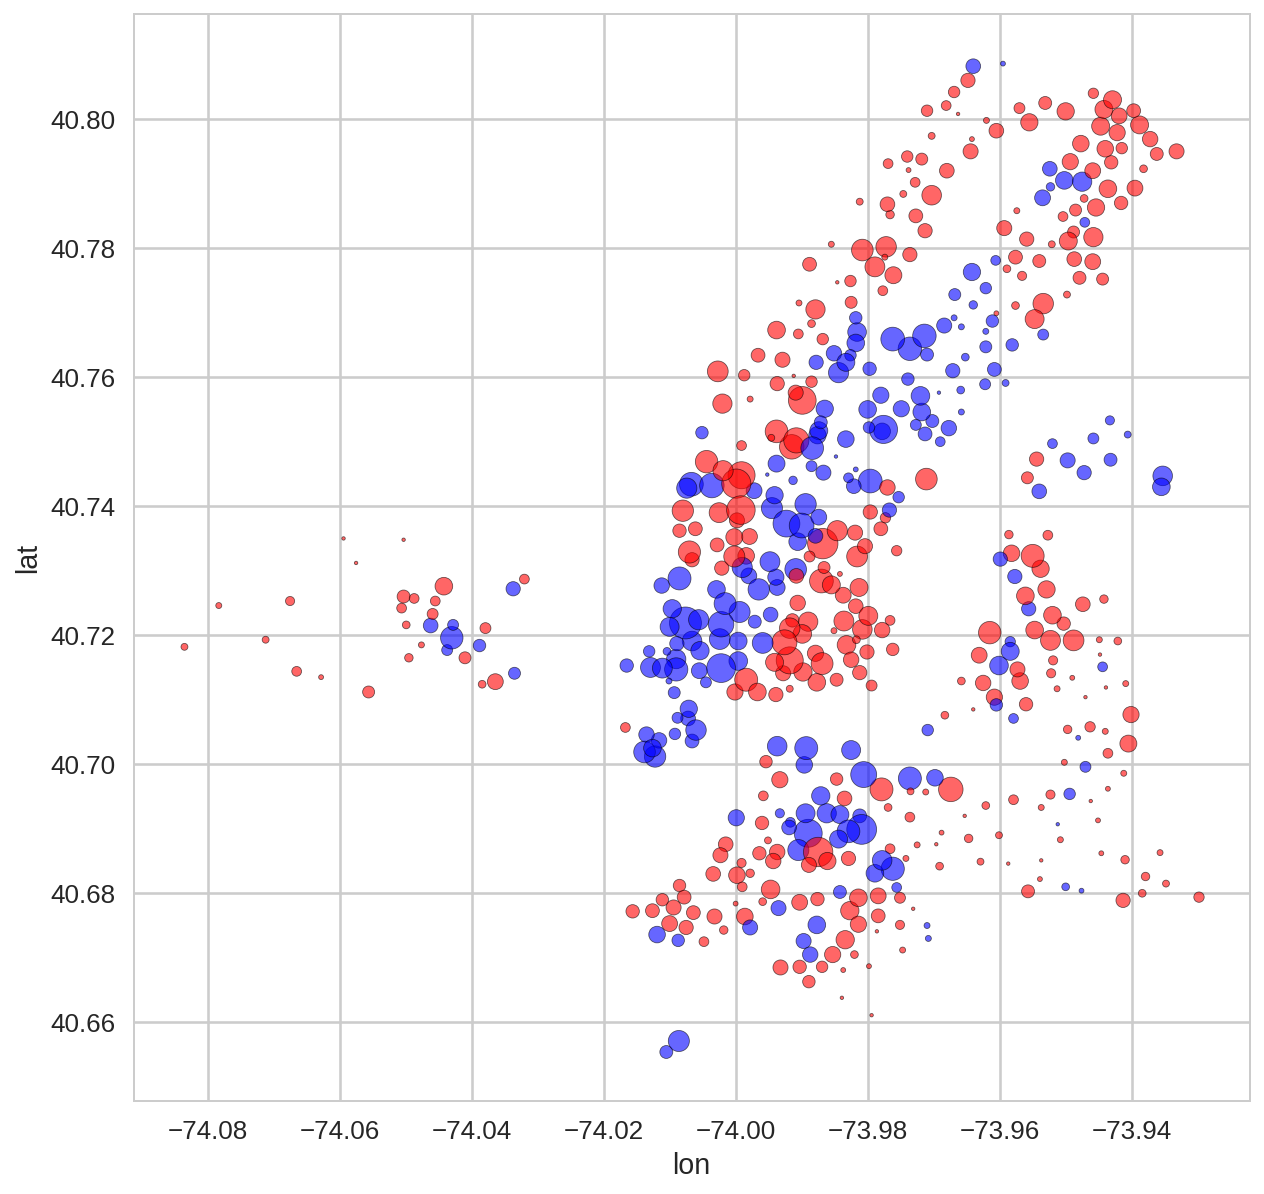

In [34]:
# Plot the stations using a scatterplot with their lon/lat values
# Use a different color for each cluster
# Change the size of each dot according to the capacity
map_df.plot.scatter(
    x = 'lon',
    y = 'lat',
    edgecolors='Black',
    c = map_df.color.values,
    s = 3*map_df.bikes_available.values,
    figsize=(10,10), alpha=0.6
)


<AxesSubplot:xlabel='lon', ylabel='lat'>

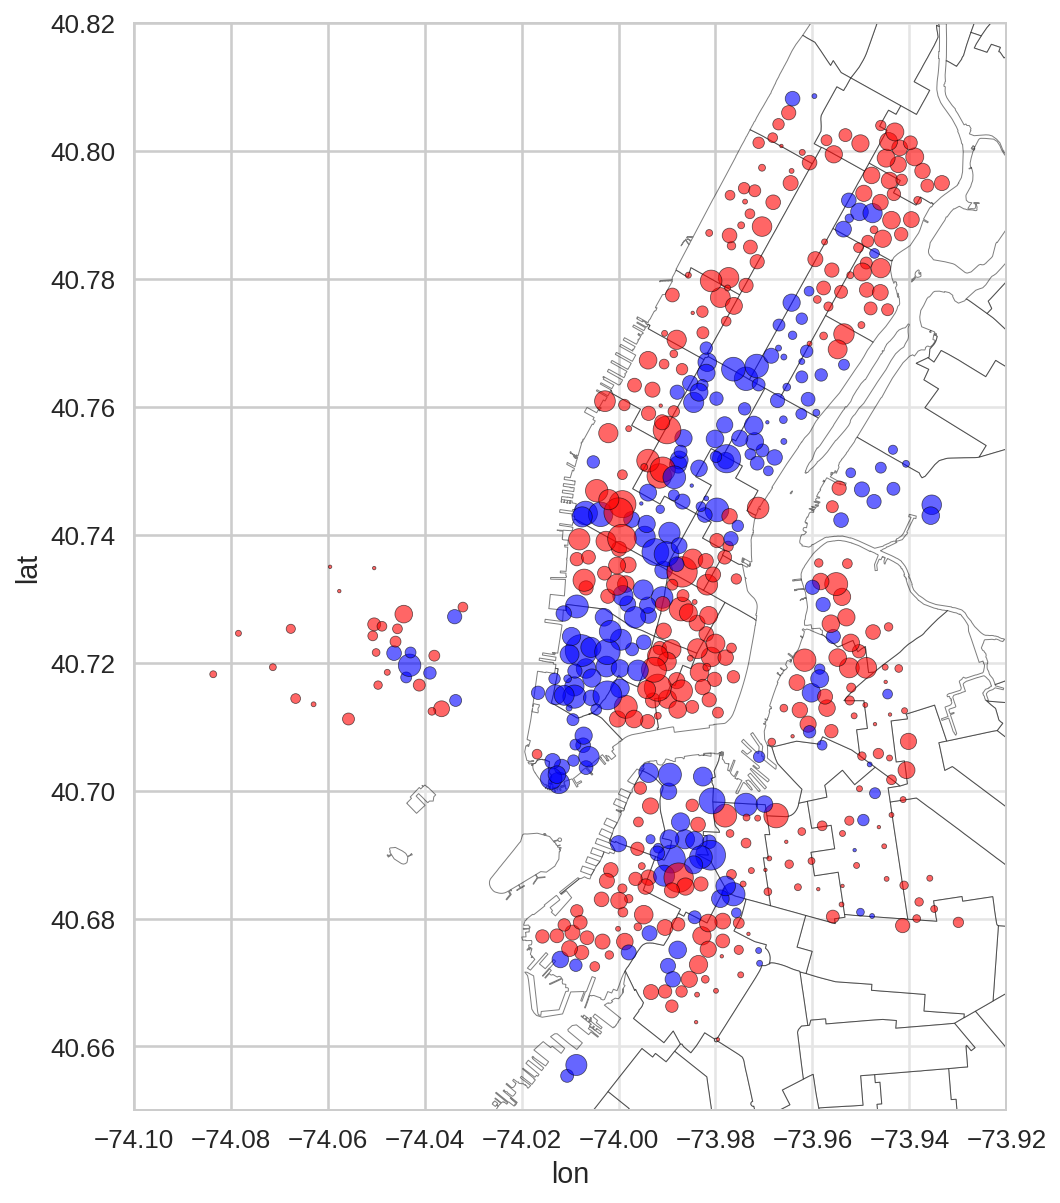

In [35]:
# We draw a background with the map of the NYC neighborhoods
import geopandas as gpd

# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
shapefile = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=Shapefile'
df_nyc = gpd.GeoDataFrame.from_file(shapefile)
# Plot the NYC neighborhoods map
base = df_nyc.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(10, 10),
    alpha=0.5)
base.set_xlim((-74.10, -73.92))
base.set_ylim((40.65, 40.82))

map_df.plot.scatter(
    x='lon',
    y='lat',
    edgecolors='Black',
    c=map_df.color.values,
    s=3 * map_df.bikes_available.values,
    figsize=(10, 10),
    alpha=0.6,
    ax=base)

### Mapping with Folium

In [36]:
import folium

map_center = [map_df.lat.median(), map_df.lon.median()]
fmap = folium.Map(location=map_center, zoom_start=14,  tiles='cartodbpositron')
fmap

In [37]:
map_center = [map_df.lat.median(), map_df.lon.median()]
fmap = folium.Map(location=map_center, zoom_start=13,  tiles='cartodbpositron')

for name, row in map_df.iterrows():
    
    # Define the opacity of the marker to be proportional to the percentage of bikes in the station
    # opacity = row["bikes_available"]/row["capacity"]
    # Make the color green for the working stations, red otherwise
    color = row["color"]
    # The size of the marker is proportional to the number of docks
    size1 = row["capacity"]/7+1
    size2 = row["bikes_available"]/7+1

    
    # We create a marker on the map with size proportional to its capacity
    folium.CircleMarker(location=[row["lat"], row["lon"]], 
                        radius = size1,
                        color='black', weight=1, 
                        fill=True,
                        fill_opacity = 0.25,
                        fill_color = color,
                       ).add_to(fmap)
    
    # We create a marker with size proportional to the number of bikes 
    # This will be the "internal" circle, indicating how full the station is
    # We make the opacity higher
    folium.CircleMarker(location=[row["lat"], row["lon"]], 
                        radius = size2,
                        color='black', weight=0.5, 
                        fill=True,
                        fill_opacity = 0.75,
                        fill_color=color,
                       ).add_to(fmap)
    


In [38]:
fmap

In [39]:
# Save the map as HTML (citibike.html). Also add the NYC neighborhoods 

# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nyc_neighborhoods = gpd.GeoDataFrame.from_file(url)
style_function = lambda x: {'fillOpacity': 0.0, 'weight': 0.5}
folium.GeoJson(
    nyc_neighborhoods,
    name='geojson', 
    style_function=style_function
).add_to(fmap)

import os
fn='citibike.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
fmap.save(fn)